If you download the dataset from Kaggle, which is the only place I can find it in 2024, the LiDAR data is in .pkl files. The PandaSet devkit is expecting .pkl.gz files. The code below compresses all the .pkl files in the dataset into .pkl.gz. *This will take a long time.* (Thank you Scale.)

In [1]:
!pwd

/Users/jamescook/ML/adpanda


In [2]:
"""

import os
import gzip
import shutil

for i in range(1, 48):
    try:
        directory_number = str(i).zfill(3)
        directory = f'./data/{directory_number}/lidar'
        for filename in os.listdir(directory):
            if filename.endswith('.pkl'):
                gz_filename = filename + '.gz'
                with open(os.path.join(directory, filename), 'rb') as f_in:
                    with gzip.open(os.path.join(directory, gz_filename), 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
        print(f'Finished converting directory {directory_number}')
    except FileNotFoundError:
        print('No such directory.')

"""

"\n\nimport os\nimport gzip\nimport shutil\n\nfor i in range(1, 48):\n    try:\n        directory_number = str(i).zfill(3)\n        directory = f'./data/{directory_number}/lidar'\n        for filename in os.listdir(directory):\n            if filename.endswith('.pkl'):\n                gz_filename = filename + '.gz'\n                with open(os.path.join(directory, filename), 'rb') as f_in:\n                    with gzip.open(os.path.join(directory, gz_filename), 'wb') as f_out:\n                        shutil.copyfileobj(f_in, f_out)\n        print(f'Finished converting directory {directory_number}')\n    except FileNotFoundError:\n        print('No such directory.')\n\n"

Once the .pkl files have been compressed, they can be loaded and displayed as pandas dataframes. We then look at a sequence using matplotlib. 

In [3]:
from pandaset import DataSet
dataset = DataSet('./data1')

seq002 = dataset['002']
seq002.load()

pc0 = seq002.lidar[0]
print(pc0)


                 x           y         z     i             t  d
index                                                          
0       -75.131138  -79.331690  3.511804   7.0  1.557540e+09  0
1      -112.588306 -118.666002  1.423499  31.0  1.557540e+09  0
2       -42.085902  -44.384891  0.593491   7.0  1.557540e+09  0
3       -27.329435  -28.795053 -0.403781   0.0  1.557540e+09  0
4        -6.196208   -6.621082  1.130009   3.0  1.557540e+09  0
...            ...         ...       ...   ...           ... ..
166763   27.670526   17.159726  3.778677  25.0  1.557540e+09  1
166764   27.703935   17.114063  3.780626  27.0  1.557540e+09  1
166765   27.560664   16.955518  3.767948  18.0  1.557540e+09  1
166766   27.384433   16.783824  3.752670  22.0  1.557540e+09  1
166767   27.228821   16.626038  3.739154  20.0  1.557540e+09  1

[166768 rows x 6 columns]


And now, just kind of trying to figure out what I have. I don't think this will be productive (*it wasn't*), but let's look at the LiDAR point clouds in matplotlib as just a 3D scatter plot:

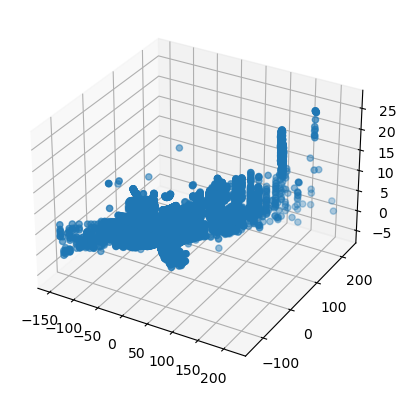

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pc0['x'], pc0['y'], pc0['z'])
plt.show()

In [12]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gzip
import pickle


dataset_path = './data/001'
annotations_path = os.path.join(dataset_path, 'annotations', 'cuboids')
images_path = os.path.join(dataset_path, 'camera', 'front_camera')

# load the annotations
annotations = []
for filename in sorted(os.listdir(annotations_path)):
    if filename.endswith('.pkl'):
        filepath = os.path.join(annotations_path, filename)
        with open(filepath, 'rb') as f:
            try:
                data = pickle.load(f)
                if not data.empty:
                    annotations.append(data)
                else:
                    print(f'Warning: {filepath} is empty.')
            except Exception as e:
                print(f'Error reading {filepath}: {e}')

# load the images
images = []
for filename in os.listdir(images_path):
    if filename.endswith('.jpg'):
        img = cv2.imread(os.path.join(images_path, filename))
        images.append(img)

# convert to numpy arrays
for i, df in enumerate(annotations):
    arr = df.to_numpy()
    print(f'Annotations for image {i} have shape {arr.shape}')
images = np.array(images)


X_train, X_test, y_train, y_test = train_test_split(images, annotations, test_size=0.2, random_state=42)

# normalize the image data
X_train = X_train / 255.0
X_test = X_test / 255.0

# use MobileNetV2 as the base model for transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add a new top layer
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# instantiate model
model = Model(inputs=base_model.input, outputs=predictions)

# first train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

Annotations for image 0 have shape (151, 17)
Annotations for image 1 have shape (155, 17)
Annotations for image 2 have shape (158, 17)
Annotations for image 3 have shape (158, 17)
Annotations for image 4 have shape (159, 17)
Annotations for image 5 have shape (159, 17)
Annotations for image 6 have shape (159, 17)
Annotations for image 7 have shape (160, 17)
Annotations for image 8 have shape (160, 17)
Annotations for image 9 have shape (160, 17)
Annotations for image 10 have shape (160, 17)
Annotations for image 11 have shape (161, 17)
Annotations for image 12 have shape (161, 17)
Annotations for image 13 have shape (162, 17)
Annotations for image 14 have shape (162, 17)
Annotations for image 15 have shape (162, 17)
Annotations for image 16 have shape (162, 17)
Annotations for image 17 have shape (162, 17)
Annotations for image 18 have shape (162, 17)
Annotations for image 19 have shape (162, 17)
Annotations for image 20 have shape (162, 17)
Annotations for image 21 have shape (163, 17

ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 64
'y' sizes: 137, 138, 141, 145, 160, 138, 159, 141, 148, 138, 144, 140, 162, 147, 140, 132, 160, 140, 140, 162, 138, 162, 144, 162, 136, 158, 162, 145, 160, 138, 159, 146, 137, 139, 143, 134, 162, 162, 144, 162, 140, 163, 144, 136, 139, 161, 156, 137, 138, 138, 137, 145, 160, 155, 140, 163, 158, 163, 137, 162, 138, 137, 162, 140


So, it appears each annotation corresponds to multiple bounding boxes in each image; to simplify temporarily, we transform the problem into a binary classification problem where for each pixel in the image, the model predicts whether the pixel belongs to an object or not (foreground vs. background). We also need to resize the images.

In [15]:
# load and resize the images
images = []
for filename in os.listdir(images_path):
    if filename.endswith('.jpg'):
        img = cv2.imread(os.path.join(images_path, filename))
        img_resized = cv2.resize(img, (224, 224))  # resize the image
        images.append(img_resized)

# convert to numpy arrays
for i, df in enumerate(annotations):
    arr = df.to_numpy()
    print(f'Annotations for image {i} have shape {arr.shape}')

images = np.array(images)

X_train, X_test, y_train, y_test = train_test_split(images, annotations, test_size=0.2, random_state=42)

# normalize the image data
X_train = X_train / 255.0
X_test = X_test / 255.0

# use MobileNetV2 as the base model for transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add a new top layer
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# convert the lists to numpy arrays
y_train_flat = np.array([np.any(a) for a in y_train])
y_test_flat = np.array([np.any(a) for a in y_test])

# train the model with the numpy arrays
model.fit(X_train, y_train_flat, validation_data=(X_test, y_test_flat), epochs=10, batch_size=32)

# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_flat)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


Annotations for image 0 have shape (151, 17)
Annotations for image 1 have shape (155, 17)
Annotations for image 2 have shape (158, 17)
Annotations for image 3 have shape (158, 17)
Annotations for image 4 have shape (159, 17)
Annotations for image 5 have shape (159, 17)
Annotations for image 6 have shape (159, 17)
Annotations for image 7 have shape (160, 17)
Annotations for image 8 have shape (160, 17)
Annotations for image 9 have shape (160, 17)
Annotations for image 10 have shape (160, 17)
Annotations for image 11 have shape (161, 17)
Annotations for image 12 have shape (161, 17)
Annotations for image 13 have shape (162, 17)
Annotations for image 14 have shape (162, 17)
Annotations for image 15 have shape (162, 17)
Annotations for image 16 have shape (162, 17)
Annotations for image 17 have shape (162, 17)
Annotations for image 18 have shape (162, 17)
Annotations for image 19 have shape (162, 17)
Annotations for image 20 have shape (162, 17)
Annotations for image 21 have shape (163, 17

100% accuracy might indicate overfitting. Let's try some other metrics on it, namely precision, recall, and F1 score (their harmonic mean).

In [17]:
from tensorflow.keras import metrics

# load and resize the images
images = []
for filename in os.listdir(images_path):
    if filename.endswith('.jpg'):
        img = cv2.imread(os.path.join(images_path, filename))
        img_resized = cv2.resize(img, (224, 224))  # resize the image
        images.append(img_resized)

# convert to numpy arrays
for i, df in enumerate(annotations):
    arr = df.to_numpy()

images = np.array(images)

X_train, X_test, y_train, y_test = train_test_split(images, annotations, test_size=0.2, random_state=42)

# normalize the image data
X_train = X_train / 255.0
X_test = X_test / 255.0

# use MobileNetV2 as the base model for transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add a new top layer
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# first train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy', 
                       metrics.Precision(), 
                       metrics.Recall(), 
                       metrics.AUC()])


# convert the lists to numpy arrays
y_train_flat = np.array([np.any(a) for a in y_train])
y_test_flat = np.array([np.any(a) for a in y_test])

# train the model with the numpy arrays
model.fit(X_train, y_train_flat, validation_data=(X_test, y_test_flat), epochs=10, batch_size=32)

# evaluate the model
results = model.evaluate(X_test, y_test_flat)

print(f'Test loss: {results[0]}')
print(f'Test accuracy: {results[1]}')
print(f'Test precision: {results[2]}')
print(f'Test recall: {results[3]}')
print(f'Test AUC: {results[4]}')


Annotations for image 0 have shape (151, 17)
Annotations for image 1 have shape (155, 17)
Annotations for image 2 have shape (158, 17)
Annotations for image 3 have shape (158, 17)
Annotations for image 4 have shape (159, 17)
Annotations for image 5 have shape (159, 17)
Annotations for image 6 have shape (159, 17)
Annotations for image 7 have shape (160, 17)
Annotations for image 8 have shape (160, 17)
Annotations for image 9 have shape (160, 17)
Annotations for image 10 have shape (160, 17)
Annotations for image 11 have shape (161, 17)
Annotations for image 12 have shape (161, 17)
Annotations for image 13 have shape (162, 17)
Annotations for image 14 have shape (162, 17)
Annotations for image 15 have shape (162, 17)
Annotations for image 16 have shape (162, 17)
Annotations for image 17 have shape (162, 17)
Annotations for image 18 have shape (162, 17)
Annotations for image 19 have shape (162, 17)
Annotations for image 20 have shape (162, 17)
Annotations for image 21 have shape (163, 17

In [18]:
print(f"Number of positive samples in training data: {(y_train_flat == 1).sum()}")
print(f"Number of negative samples in training data: {(y_train_flat == 0).sum()}")

print(f"Number of positive samples in test data: {(y_test_flat == 1).sum()}")
print(f"Number of negative samples in test data: {(y_test_flat == 0).sum()}")


Number of positive samples in training data: 64
Number of negative samples in training data: 0
Number of positive samples in test data: 16
Number of negative samples in test data: 0


OK, that's why the AUC is 0... let's synthesize some negative samples this time.

In [19]:
# create synthetic negative samples by flipping the images horizontally
images_flipped = np.flip(images, axis=2)
annotations_flipped = [pd.DataFrame(np.zeros_like(a), columns=a.columns) for a in annotations]

# combine the original and synthetic samples
images = np.concatenate((images, images_flipped))
annotations = annotations + annotations_flipped

X_train, X_test, y_train, y_test = train_test_split(images, annotations, test_size=0.2, random_state=42)

# normalize the image data
X_train = X_train / 255.0
X_test = X_test / 255.0

# use MobileNetV2 as the base model for transfer learning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add a new top layer
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# first train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy', 
                       metrics.Precision(), 
                       metrics.Recall(), 
                       metrics.AUC()])


# convert the lists to numpy arrays
y_train_flat = np.array([np.any(a) for a in y_train])
y_test_flat = np.array([np.any(a) for a in y_test])

# train the model with the numpy arrays
model.fit(X_train, y_train_flat, validation_data=(X_test, y_test_flat), epochs=10, batch_size=32)

# evaluate the model
results = model.evaluate(X_test, y_test_flat)

print(f'Test loss: {results[0]}')
print(f'Test accuracy: {results[1]}')
print(f'Test precision: {results[2]}')
print(f'Test recall: {results[3]}')
print(f'Test AUC: {results[4]}')


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.6833 - auc_2: 0.8140 - loss: 0.6600 - precision_2: 0.6403 - recall_2: 0.7088 - val_accuracy: 1.0000 - val_auc_2: 1.0000 - val_loss: 1.4685e-06 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 5.5775e-13 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 1.0000 - val_auc_2: 1.0000 - val_loss: 8.9947e-17 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 1.0000 - auc_2: 1.0000 - loss: 4.3182e-09 - precision_2: 1.0000 - recall_2: 1.0000 - val_accuracy: 1.0000 - val_auc_2: 1.0000 - val_loss: 4.7397e-16 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9948 - auc_2: 1.0000 - loss: 0.0272 - precision_2: 0.9899 - recall_2: 1.0000 - val_accuracy: 1.0000 - val_auc_2: 1.0000 - val_loss: 2.1524e-19 - val_precision_2: 1.0000 - v

In [20]:
print(f"Number of positive samples in training data: {(y_train_flat == 1).sum()}")
print(f"Number of negative samples in training data: {(y_train_flat == 0).sum()}")

print(f"Number of positive samples in test data: {(y_test_flat == 1).sum()}")
print(f"Number of negative samples in test data: {(y_test_flat == 0).sum()}")


Number of positive samples in training data: 64
Number of negative samples in training data: 64
Number of positive samples in test data: 16
Number of negative samples in test data: 16
